### 3-star isochrone fitting

In [1]:
from jaxstar import mistfit
from jax import random
import arviz, corner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpyro.infer import init_to_value, MCMC, NUTS
import arviz as az 
import numpyro, jax
num_chains = 4
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())
from pathlib import Path
from jaxspec.specfit import SpecFit
from numpyro_model_3star import *

# jax device count: 4


In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=False)

In [ ]:
def run_3star(sf, alpha, kmag_obs, kmag_err, teff_obs, feh_obs, parallax_obs, parallax_err, fratio_obs, fratio_err, save=None, num_samples=1500, acc=0.95): 
    teff_err, feh_err = 100 * np.ones(3), 0.1 # assumed
    flux_ratio_obs = {'fratio': [fratio_obs, fratio_err]}

    mf = mistfit.MistFit()
    mf.set_data(['kmag', 'teff', 'feh', 'parallax'],\
            [kmag_obs, teff_obs, feh_obs, parallax_obs],\
            [kmag_err, teff_err, feh_err, parallax_err])

    pdict = init_dict(mf)
    pdict['eep'] = 350 * np.ones(3)
    pdict['logage'] = np.log10(5e9)

    init_strategy = init_to_value(values=pdict)
    kernel = NUTS(model_unresolved_multiple, init_strategy=init_strategy, dense_mass=True, target_accept_prob=acc)
    mcmc = MCMC(kernel, num_warmup=num_samples, num_samples=num_samples, num_chains=num_chains)

    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mf, sf, alpha=alpha, nstar=3, flux_ratio_obs=flux_ratio_obs)
    mcmc.print_summary()

    idata = az.from_numpyro(mcmc)

    fig = az.plot_trace(idata, var_names=['age', 'distance', 'eep', 'feh_init'], compact=False)
    plt.tight_layout()

    m1 = idata.posterior['mass'][:,:,0]
    m2 = idata.posterior['mass'][:,:,1] + idata.posterior['mass'][:,:,2]
    idata.posterior['fm'] = m2**3 / (m1 + m2)**2
    
    var_names = ['kmag_total'] + mf.obskeys + ['feh_init', 'mass', 'radius', 'age'] + ['f2', 'f3'] + ['fm']
    for i,key in enumerate(mf.obskeys):
        if 'mag' in key:
            obsvals = np.array([mf.obsvals[0]])
            obsvals = np.r_[obsvals, [None]*3]
        else:
            obsvals = np.r_[obsvals, mf.obsvals[i]]
    obsvals = np.r_[obsvals, [None]*8]
    obsvals = np.r_[obsvals, flux_ratio_obs['fratio'][0], None]

    fig = corner.corner(idata, var_names=var_names, show_titles=True, title_fmt='.3f', truths=obsvals)
    plt.savefig(f"isochrone_output/{save}_corner.png", dpi=200, bbox_inches="tight")

    return idata

In [ ]:
# load spectrum grid
def load_spectrum(datapath, orders, pct_threshold=10., numpix=3000, remove_trend=False):
    orders = np.atleast_1d(orders)
    data = pd.read_csv(datapath)
    wav_obs = np.array(data.lam).reshape(-1,numpix)[orders,:]
    flux_obs = np.array(data.flux).reshape(-1,numpix)[orders,:]
    error_obs = np.ones_like(flux_obs) * 5e-3
    mask_obs = ~(flux_obs == flux_obs)
    flux_obs = np.where(flux_obs == flux_obs, flux_obs, 1.)
    return [wav_obs, flux_obs, error_obs, mask_obs]

gridpath = str(Path("~/data/specgrid_absolute_hdsYbred_coelho").expanduser()) + "/" # path to synthetic grid; can be downloaded from https://www.dropbox.com/scl/fi/1gv1iisn0gb95csu9ribb/specgrid_absolute_hdsYbred_coelho.tar.gz?rlkey=1y12lbqgx8d6nbw334h4udxsf&dl=0
orders = np.arange(1,7)
physical_logg_max = True
empirical_vmacro = True
resolution = 90000
vmax = 50.

wav_obs, flux_obs, error_obs, mask_obs = load_spectrum("data/subaru_250406_g1010_Yb_R12.csv", orders)

sf = SpecFit(str(gridpath), [wav_obs, flux_obs, error_obs, mask_obs], orders, vmax=vmax, wav_margin=3.)
sf.wavresmin = np.array([resolution] * len(sf.orders))
sf.wavresmax = np.array([resolution] * len(sf.orders))

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       age     11.85      1.48     12.17      9.70     13.80    996.55      1.00
  distance      0.47      0.03      0.47      0.42      0.51   1858.56      1.00
    eep[0]    418.68     12.02    419.93    398.92    438.10   1049.81      1.00
    eep[1]    340.64      4.08    341.39    334.42    347.08    941.66      1.00
    eep[2]    337.65      4.12    338.41    331.23    343.85    932.03      1.00
  feh_init     -0.33      0.09     -0.33     -0.47     -0.19   2804.37      1.00

Number of divergences: 6


'g1010_chains.json'

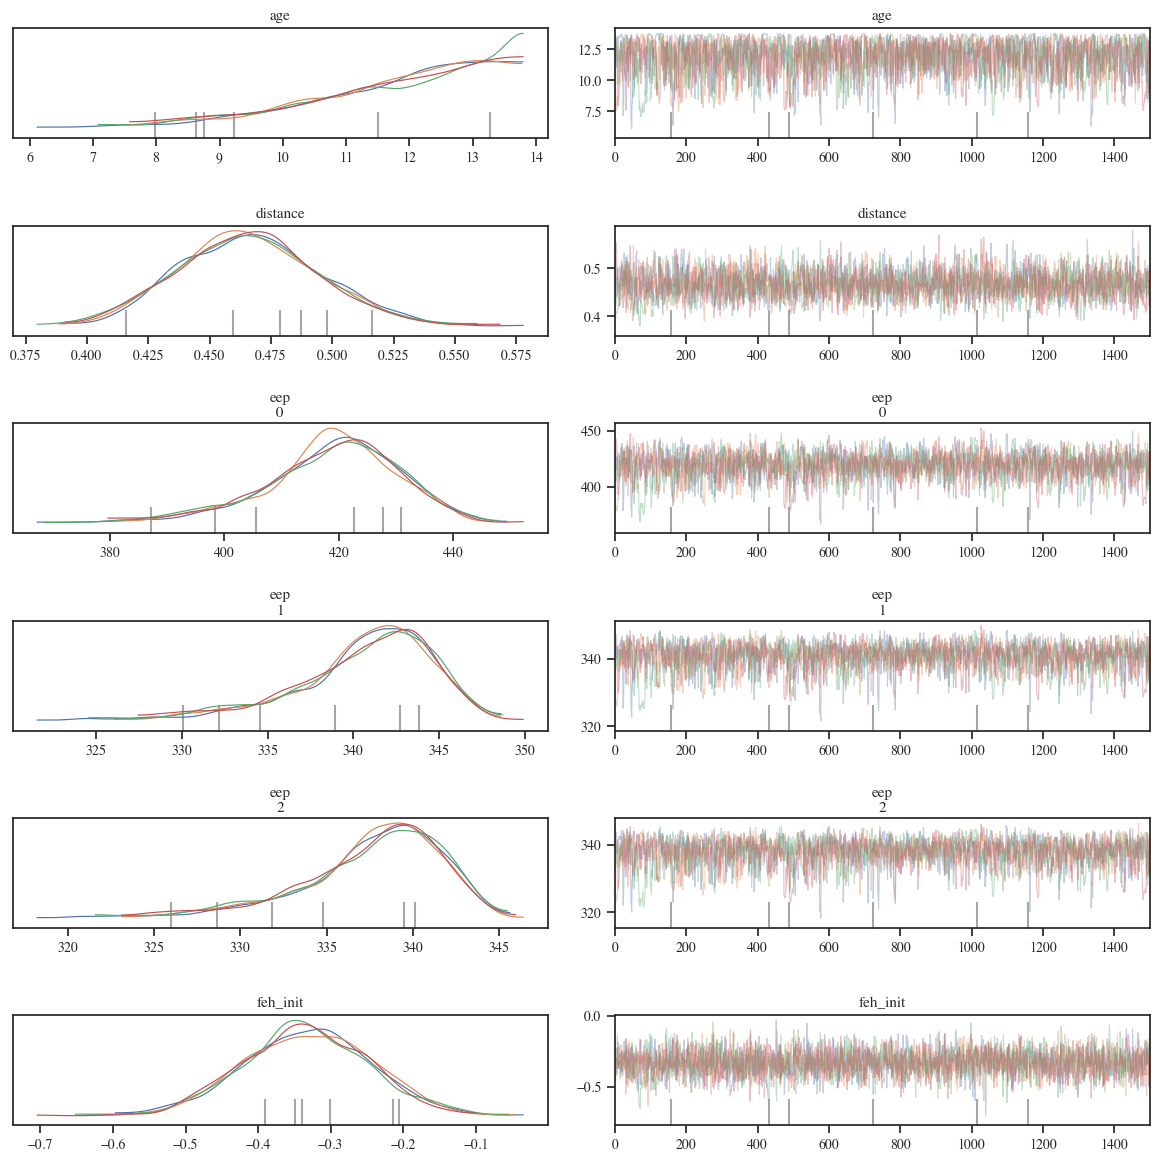

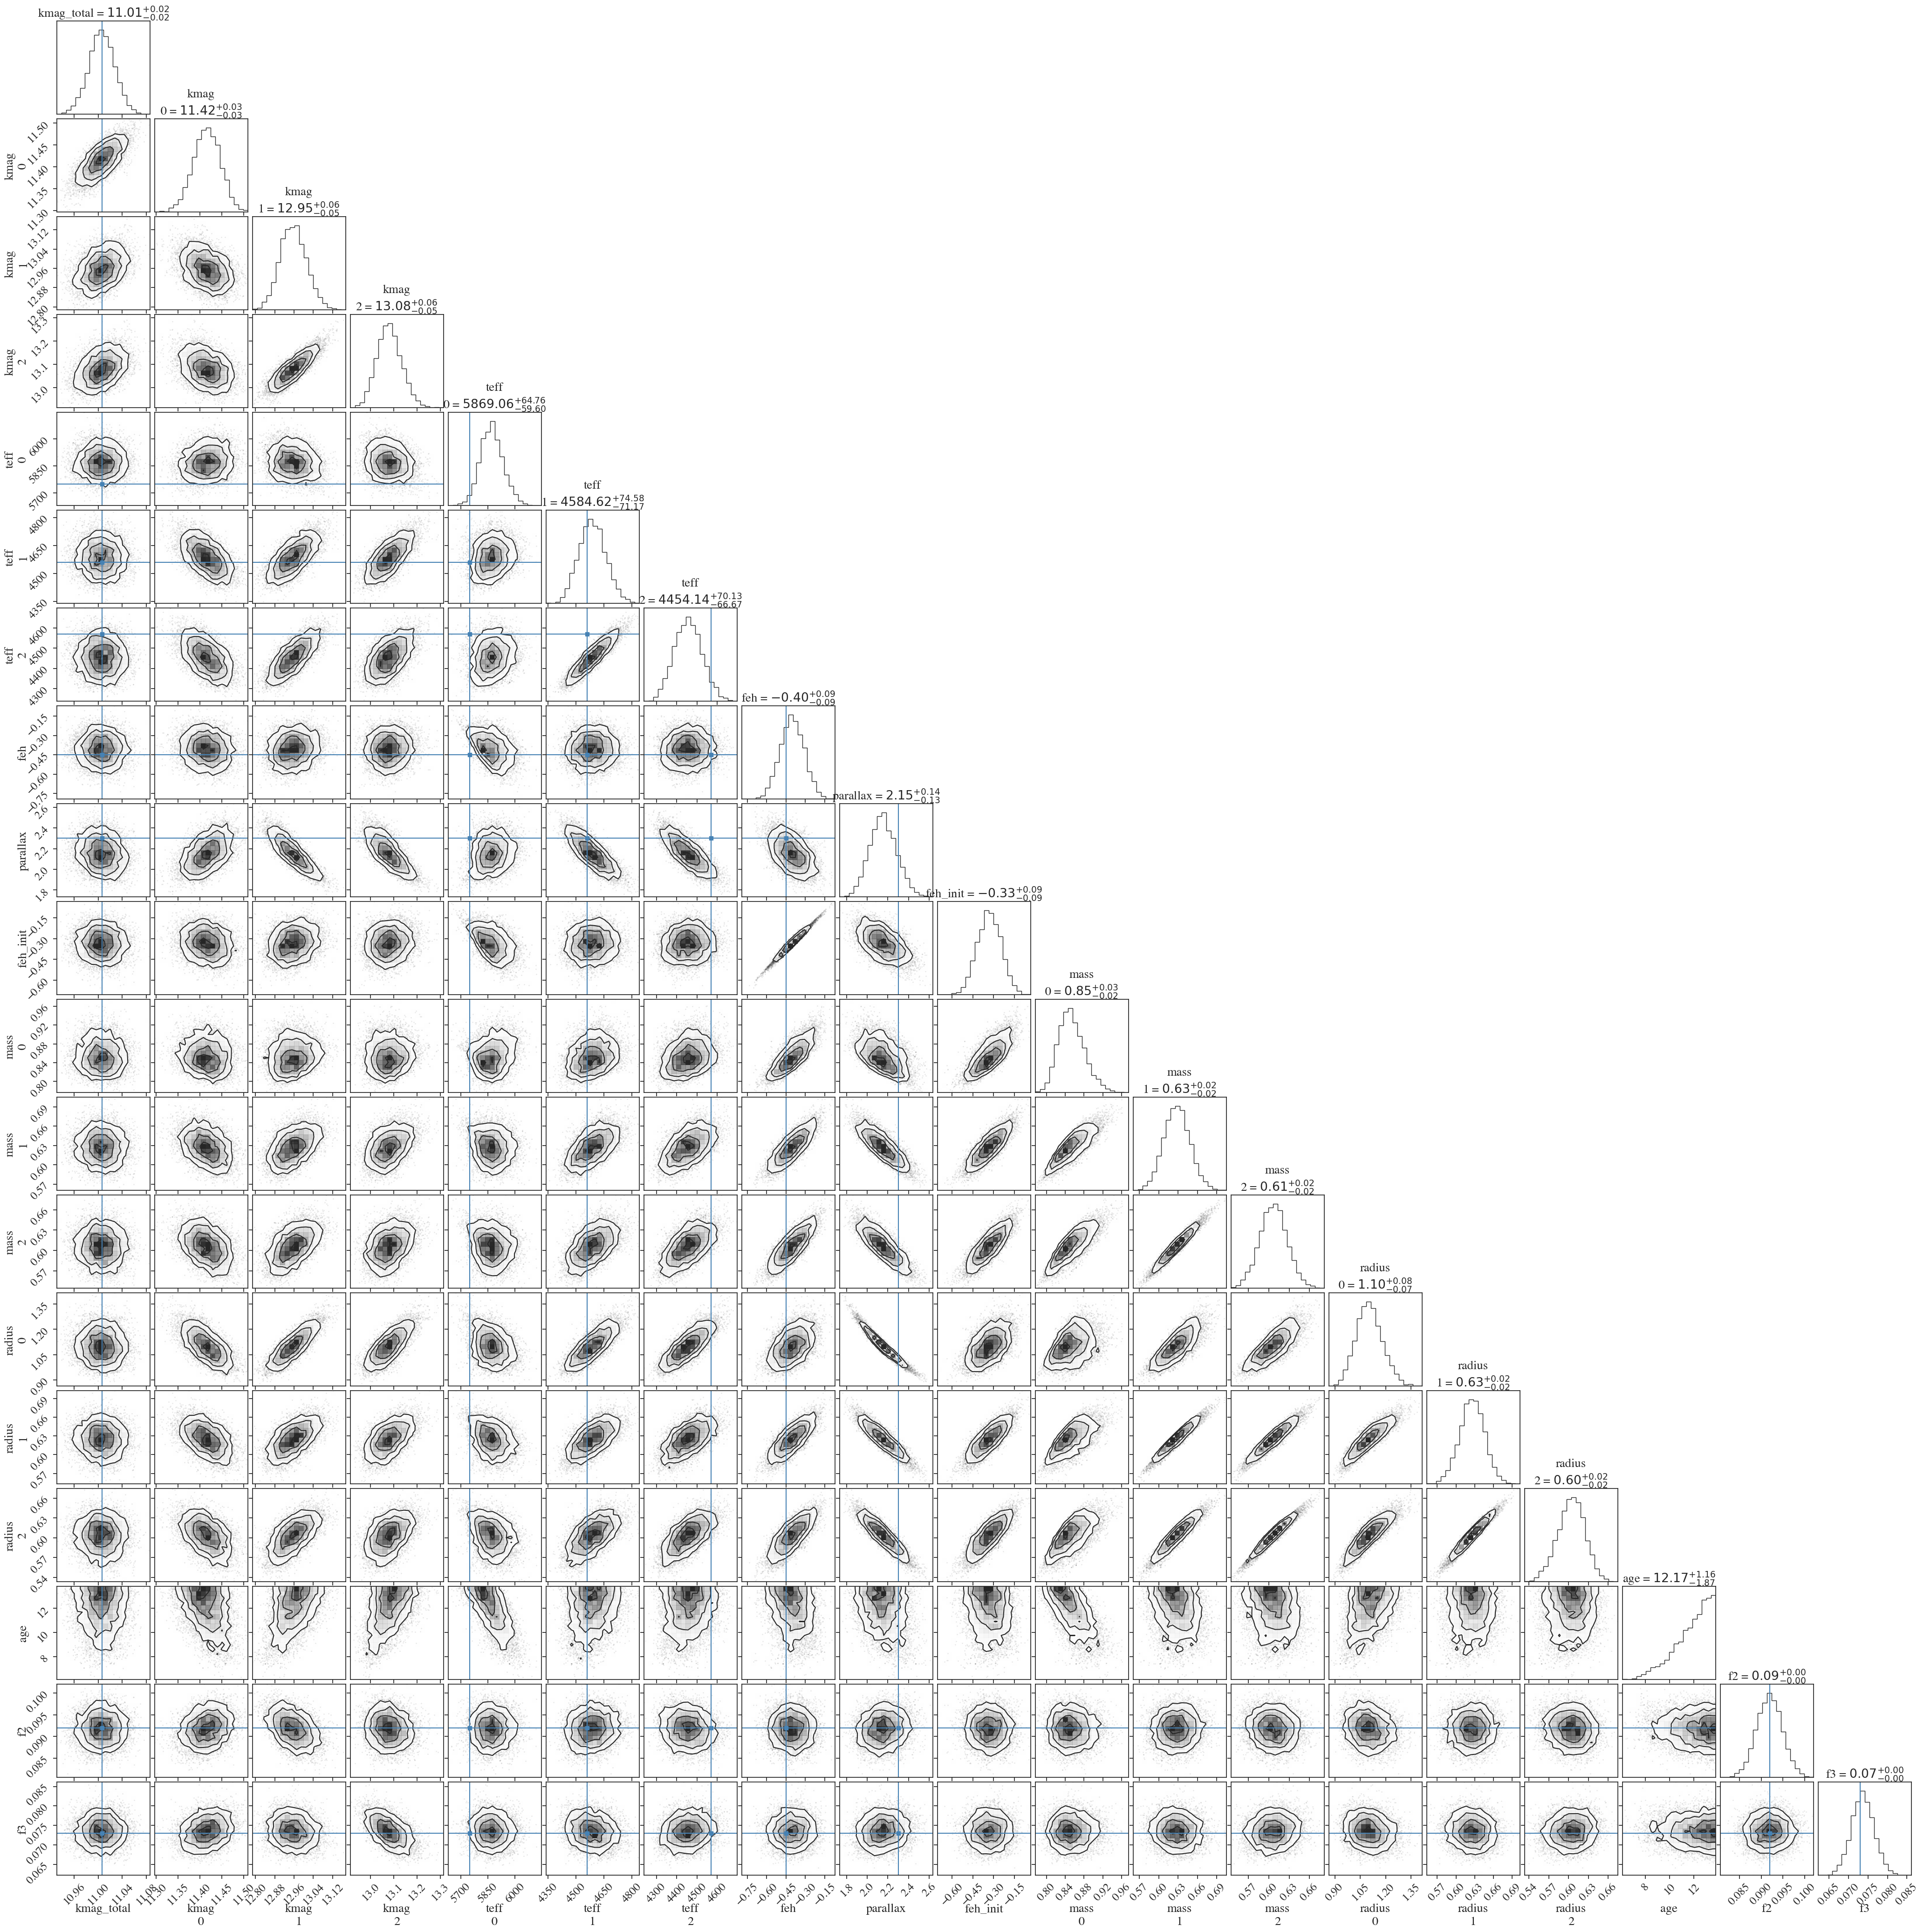

In [ ]:
# G1010
name = 'g1010'
ebv = 0.107
Ak = 0.3026 * ebv # Green+2019
Ak_err = 0.3 * Ak
kmag_obs, kmag_err, teff_obs, feh_obs, parallax_obs, parallax_err\
= [11.039-Ak, np.sqrt(0.02**2 + Ak_err**2), np.array([5750., 4560., 4570.]), -0.45, 2.302, 0.074*3.34]
alpha_obs = 0.
fratio_obs = np.array([0.092, 0.073])
fratio_err = np.array([0.003, 0.003])

idata = run_3star(sf, alpha_obs, kmag_obs, kmag_err, teff_obs, feh_obs, parallax_obs, parallax_err, fratio_obs, fratio_err, save=name)
idata.to_json(f"isochrone_output/{name}_chains.json")